In [1]:
# ---- Preamble ----
import os, numpy as np, pandas as pd
import matplotlib.pyplot as plt

# Reuse helpers from 01_exploration; paste here if needed
def ewma_by_engine(scores, meta, alpha=0.2):
    out = np.zeros_like(scores, dtype=float)
    dfm = pd.DataFrame({"uid": meta[:,0], "score": scores})
    for uid, idx in dfm.groupby("uid").groups.items():
        idx = list(idx)
        s = scores[idx]
        sm = np.empty_like(s, dtype=float)
        sm[0] = s[0]
        for i in range(1, len(s)):
            sm[i] = alpha*s[i] + (1-alpha)*sm[i-1]
        out[idx] = sm
    return out

def first_alert_cycle(meta, alerts, uid):
    m = meta[:,0] == uid
    cyc = meta[m,1]
    a = alerts[m]
    return int(cyc[a][0]) if a.any() else None

def first_cycle_where_RUL_leq(df, uid, W, T=30):
    g = df[df["unit"]==uid].sort_values("cycle")
    m = g["RUL"].values <= T
    if m.any():
        return int(g["cycle"].values[np.argmax(m)])
    return None


In [2]:
# ---- Load artifacts (optional) ----
# Skip this if X, meta, healthy_win are already in memory from previous notebook session
npz_dir = "artifacts_fd001"
if os.path.isdir(npz_dir):
    X = np.load(f"{npz_dir}/X.npy")
    meta = np.load(f"{npz_dir}/meta.npy")
    healthy_win = np.load(f"{npz_dir}/healthy_win.npy")
    print("Loaded:", X.shape, meta.shape, healthy_win.shape)
else:
    print("Artifacts folder not found; using in-memory variables from 01_exploration if available.")


Loaded: (17731, 30, 7) (17731, 2) (17731,)


In [3]:
# ---- PyTorch LSTM Autoencoder ----
# If torch isn't installed yet:
# !pip install --index-url https://download.pytorch.org/whl/cpu torch==2.3.1 torchvision==0.18.1 torchaudio==2.3.1

import torch, torch.nn as nn
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
W, F = X.shape[1], X.shape[2]

class LSTMAE(nn.Module):
    def __init__(self, n_feat, hidden=64, latent=16):
        super().__init__()
        self.enc = nn.LSTM(n_feat, hidden, batch_first=True)
        self.to_z = nn.Linear(hidden, latent)
        self.dec_init = nn.Linear(latent, hidden)
        self.dec = nn.LSTM(n_feat, hidden, batch_first=True)
        self.out = nn.Linear(hidden, n_feat)
    def forward(self, x):
        # Encoder → latent
        h_enc, _ = self.enc(x)               # (B,T,H)
        z = self.to_z(h_enc[:,-1])           # (B,latent)
        # Decoder with zero inputs (simple teacher-forcing proxy)
        h0 = torch.tanh(self.dec_init(z)).unsqueeze(0)  # (1,B,H)
        c0 = torch.zeros_like(h0)
        x_in = torch.zeros_like(x)           # zeros of shape (B,T,F)
        h_dec, _ = self.dec(x_in, (h0, c0))
        xhat = self.out(h_dec)               # (B,T,F)
        return xhat


In [4]:
# ---- Training loop ----
Xh = torch.tensor(X[healthy_win], dtype=torch.float32, device=device)
model = LSTMAE(F, hidden=64, latent=16).to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-3)
crit = nn.SmoothL1Loss()   # robust to outliers

batch_size = 128
epochs = 10  # start small; increase after it runs end-to-end

for ep in range(epochs):
    model.train()
    perm = torch.randperm(Xh.size(0))
    total = 0.0
    for i in range(0, len(perm), batch_size):
        batch = Xh[perm[i:i+batch_size]]
        opt.zero_grad()
        xhat = model(batch)
        loss = crit(xhat, batch)
        loss.backward()
        opt.step()
        total += float(loss) * batch.size(0)
    print(f"epoch {ep+1}/{epochs}  train_loss={total/len(perm):.5f}")


epoch 1/10  train_loss=3092.49015
epoch 2/10  train_loss=3092.38980
epoch 3/10  train_loss=3091.85204
epoch 4/10  train_loss=3090.58311
epoch 5/10  train_loss=3089.36490
epoch 6/10  train_loss=3088.23865
epoch 7/10  train_loss=3087.22908
epoch 8/10  train_loss=3086.30641
epoch 9/10  train_loss=3085.44083
epoch 10/10  train_loss=3084.61459


In [5]:
# ---- Scoring ----
model.eval()
with torch.no_grad():
    X_all = torch.tensor(X, dtype=torch.float32, device=device)
    X_hat = model(X_all)
    rec_err = ((X_all - X_hat)**2).mean(dim=(1,2)).cpu().numpy()  # per-window MSE

# Smooth per engine
score_lstm = ewma_by_engine(rec_err, meta, alpha=0.2)

# Threshold from healthy windows (95th percentile of smoothed scores)
thr_lstm = float(np.percentile(score_lstm[healthy_win], 95))
alerts_lstm = score_lstm > thr_lstm

print("Threshold (LSTM-AE):", thr_lstm, "| Alert rate:", alerts_lstm.mean().round(3))


Threshold (LSTM-AE): 21922141.511170045 | Alert rate: 0.262


In [7]:
from pathlib import Path
import pandas as pd

# 1) Load FD001 quickly (same as in 01_exploration)
base = Path(r"E:\turbofan_engine\data\turbofan\CMaps")
p = base / "train_FD001.txt"

# infer column count so this works with any mirror
n_cols = len(pd.read_csv(p, sep=r"\s+", header=None, nrows=1).columns)
cols = ["unit","cycle","os1","os2","os3"] + [f"s{i}" for i in range(1, n_cols-5+1)]
df = pd.read_csv(p, sep=r"\s+", header=None, names=cols)

# 2) Compute RUL labels
rul = df.groupby("unit")["cycle"].max().rename("max_cycle")
df = df.merge(rul, on="unit")
df["RUL"] = df["max_cycle"] - df["cycle"]

# 3) Ensure W matches your window length
W = X.shape[1]  # or set W = 30 if you used that explicitly



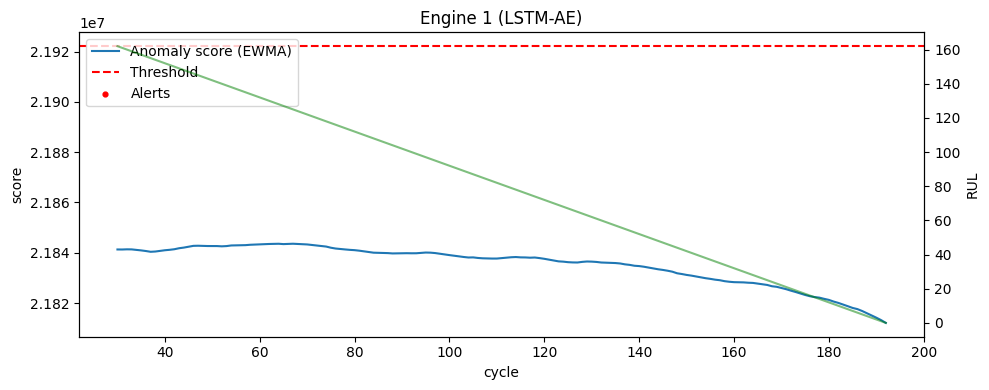

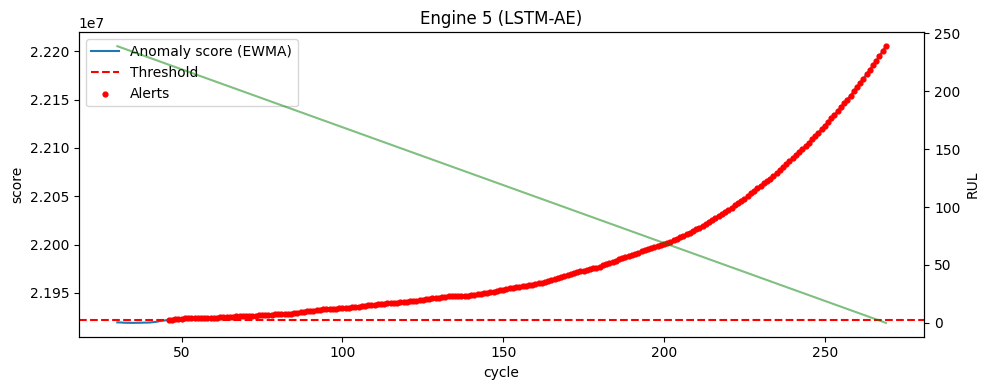

In [8]:
# ---- Comparison & visualization ----
def plot_engine_scores(uid, meta, score, alerts, thr, df=None, W=None, title_suffix=""):
    m = meta[:,0] == uid
    cyc_w = meta[m,1]
    s = score[m]
    a = alerts[m]
    fig, ax1 = plt.subplots(figsize=(10,4))
    ax1.plot(cyc_w, s, label="Anomaly score (EWMA)")
    ax1.axhline(thr, ls="--", color="r", label="Threshold")
    ax1.scatter(cyc_w[a], s[a], s=12, color="r", label="Alerts", zorder=3)
    ax1.set_xlabel("cycle"); ax1.set_ylabel("score"); ax1.legend(loc="upper left")
    if df is not None and W is not None:
        eng = df[df["unit"]==uid].sort_values("cycle")
        cyc = eng["cycle"].values[W-1:]
        rul = eng["RUL"].values[W-1:]
        ax2 = ax1.twinx()
        ax2.plot(cyc, rul, color="g", alpha=0.5, label="RUL")
        ax2.set_ylabel("RUL")
    plt.title(f"Engine {uid} {title_suffix}")
    plt.tight_layout(); plt.show()

# Example visuals (requires df & W in scope; bring df from 01_exploration via %run or re-load there)
try:
    plot_engine_scores(1, meta, score_lstm, alerts_lstm, thr_lstm, df=df, W=W, title_suffix="(LSTM-AE)")
    plot_engine_scores(5, meta, score_lstm, alerts_lstm, thr_lstm, df=df, W=W, title_suffix="(LSTM-AE)")
except NameError:
    print("Note: pass df & W if you want RUL overlay.")


In [21]:
# ---- Lead-time & false-alerts ----
# requires df (with RUL), W (window size), and helper functions defined above

uids = np.unique(meta[:,0])
lead_times = []
false_before_30 = 0

for u in uids:
    t_alert = first_alert_cycle(meta, alerts_lstm, u)
    t_rul30 = first_cycle_where_RUL_leq(df, u, W, T=30)
    m = meta[:,0]==u
    cyc = meta[m,1]
    a = alerts_lstm[m]
    if t_rul30 is not None:
        false_before_30 += int((a & (cyc < t_rul30)).sum())
    if t_alert is not None and t_rul30 is not None:
        lead_times.append(t_rul30 - t_alert)

print("LSTM-AE: mean lead time to RUL<=30 (cycles):", (np.mean(lead_times) if lead_times else None))
print("LSTM-AE: false alerts before RUL<=30 (total):", false_before_30)
print("LSTM-AE: engines with at least one alert before RUL<=30:", 
      sum([lt > 0 for lt in lead_times]))


LSTM-AE: mean lead time to RUL<=30 (cycles): 51.421052631578945
LSTM-AE: false alerts before RUL<=30 (total): 2994
LSTM-AE: engines with at least one alert before RUL<=30: 51


In [22]:
import pandas as pd
import numpy as np
from pathlib import Path

F = X.shape[2]  # number of features in your windows

def load_fd001_df():
    base = Path(r"E:\turbofan_engine\data\turbofan\CMaps")
    p = base / "train_FD001.txt"
    # infer column count
    n_cols = len(pd.read_csv(p, sep=r"\s+", header=None, nrows=1).columns)
    cols = ["unit","cycle","os1","os2","os3"] + [f"s{i}" for i in range(1, n_cols-5+1)]
    df = pd.read_csv(p, sep=r"\s+", header=None, names=cols)
    # add RUL for later overlay if needed
    maxc = df.groupby("unit")["cycle"].max().rename("max_cycle")
    df = df.merge(maxc, on="unit")
    df["RUL"] = df["max_cycle"] - df["cycle"]
    return df

df_try = None
try:
    df_try = load_fd001_df()
    sensor_cols = [c for c in df_try.columns if c.startswith("s")]
    # same rule used earlier
    recomputed = [c for c in sensor_cols if df_try[c].var() > 0.5]

    # If counts mismatch, fall back to top-F variance sensors (keeps you running)
    if len(recomputed) != F:
        variances = df_try[sensor_cols].var().sort_values(ascending=False)
        fallback = list(variances.index[:F])
        print(f"[info] Recomputed useful_sensors={len(recomputed)} != X features F={F}. "
              f"Using top-{F}-variance fallback to match X.")
        useful_sensors = fallback
    else:
        useful_sensors = recomputed

    print("useful_sensors:", useful_sensors)
except Exception as e:
    print("[warn] Could not reload FD001 to rebuild names:", e)
    # Last-resort placeholder names if file isn’t available
    useful_sensors = [f"feat_{i}" for i in range(F)]
    print("Using placeholder names:", useful_sensors)


useful_sensors: ['s3', 's4', 's7', 's9', 's12', 's14', 's17']


In [23]:
import numpy as np, os
os.makedirs("artifacts_fd001", exist_ok=True)
np.save("artifacts_fd001/feature_names.npy", np.array(useful_sensors, dtype=object))
print("Saved artifacts_fd001/feature_names.npy")


Saved artifacts_fd001/feature_names.npy


In [24]:
import numpy as np, os
feat_path = "artifacts_fd001/feature_names.npy"
if os.path.exists(feat_path):
    useful_sensors = np.load(feat_path, allow_pickle=True).tolist()
    print("Loaded feature names:", useful_sensors)


Loaded feature names: ['s3', 's4', 's7', 's9', 's12', 's14', 's17']


In [25]:
import numpy as np
import matplotlib.pyplot as plt

def first_alert_idx_for_engine(uid, alerts, meta):
    m = (meta[:,0] == uid) & alerts
    idxs = np.where(m)[0]
    return int(idxs[0]) if len(idxs) else None



In [26]:
# Baseline from healthy windows (last timestep)
last_healthy = X[healthy_win, -1, :]           # (n_healthy, F)
mu = last_healthy.mean(axis=0)
sd = last_healthy.std(axis=0) + 1e-8

def topk_contrib_for_idx(idx, k=5):
    """Return [(feature_name, zscore), ...] for top-k contributors at window idx."""
    last = X[idx, -1, :]                        # (F,)
    z = np.abs((last - mu) / sd)                # (F,)
    order = np.argsort(z)[::-1][:k]
    # map feature index -> sensor name (useful_sensors holds names like 's3','s4',...)
    names = [useful_sensors[i] for i in order]
    return list(zip(names, z[order]))


No alert for engine 1.


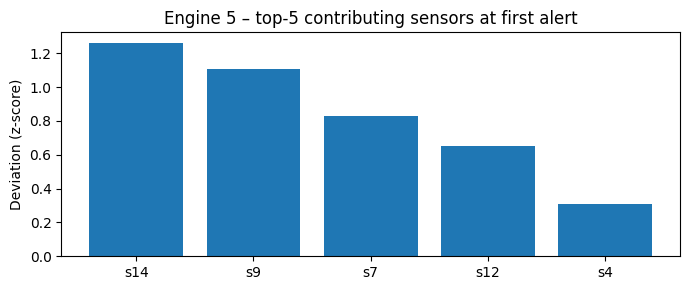

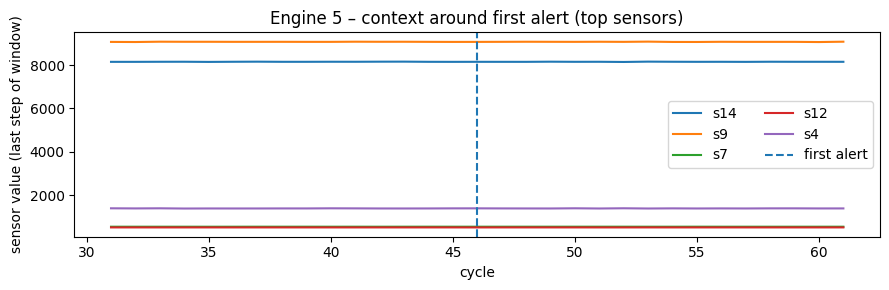

In [27]:
def plot_contributors_for_engine(uid, k=5, context_halfspan=15):
    """
    For the first alert on engine uid:
      - Show top-k contributing sensors as a bar chart (z-scores)
      - Show their time traces around the alert window (±context_halfspan cycles)
    """
    idx = first_alert_idx_for_engine(uid, alerts_lstm, meta)
    if idx is None:
        print(f"No alert for engine {uid}.")
        return

    # --- Top-k contributors at alert ---
    contrib = topk_contrib_for_idx(idx, k=k)  # [(name, z), ...]
    names, zs = zip(*contrib)

    # --- Bar plot of contributors ---
    fig, ax = plt.subplots(figsize=(7,3))
    ax.bar(names, zs)
    ax.set_ylabel("Deviation (z-score)")
    ax.set_title(f"Engine {uid} – top-{k} contributing sensors at first alert")
    plt.tight_layout(); plt.show()

    # --- Context traces around the alert window end ---
    uid_mask = meta[:,0] == uid
    cyc_all = meta[uid_mask, 1]
    # find the index within the engine's sequence
    engine_indices = np.where(uid_mask)[0]
    local_pos = np.where(engine_indices == idx)[0][0]
    start = max(0, local_pos - context_halfspan)
    end   = min(len(engine_indices)-1, local_pos + context_halfspan)

    # Plot each top sensor over the context window
    fig2, ax2 = plt.subplots(figsize=(9,3))
    for name in names:
        f_idx = useful_sensors.index(name)
        series = [ X[i, -1, f_idx] for i in engine_indices[start:end+1] ]  # last timestep per window
        ax2.plot(cyc_all[start:end+1], series, label=name)
    ax2.axvline(cyc_all[local_pos], ls="--", label="first alert")
    ax2.set_xlabel("cycle"); ax2.set_ylabel("sensor value (last step of window)")
    ax2.set_title(f"Engine {uid} – context around first alert (top sensors)")
    ax2.legend(loc="best", ncols=2)
    plt.tight_layout(); plt.show()

    # Optional: save figures for slides
    # fig.savefig(f"contributors_e{uid}.png", dpi=200)
    # fig2.savefig(f"context_e{uid}.png", dpi=200)

# Example: visualize for engines 1 and 5
plot_contributors_for_engine(1, k=5)
plot_contributors_for_engine(5, k=5)


In [28]:
# ---- Sensor contribution heuristic ----
# Use healthy windows' last timestep stats as baseline
last_healthy = X[healthy_win, -1, :]     # (n_healthy, F)
mu = last_healthy.mean(axis=0)
sd = last_healthy.std(axis=0) + 1e-8

def topk_contrib_for_idx(idx, k=3):
    last = X[idx, -1, :]
    z = np.abs((last - mu) / sd)
    top = np.argsort(z)[::-1][:k]
    return [(int(top[i]), float(z[top[i]])) for i in range(k)]  # returns sensor indexes & z

# Example: first alert for an engine
m = (meta[:,0]==1) & alerts_lstm
idxs = np.where(m)[0]
if len(idxs):
    print("Top contributors (sensor index, z) at first alert:", topk_contrib_for_idx(int(idxs[0])))


In [29]:
# ---- Save artifacts ----
os.makedirs("artifacts_fd001", exist_ok=True)
np.save("artifacts_fd001/score_smooth_lstm.npy", score_lstm)
np.save("artifacts_fd001/alerts_lstm.npy", alerts_lstm)
with open("artifacts_fd001/threshold_lstm.txt","w") as f:
    f.write(str(thr_lstm))
print("Saved LSTM-AE artifacts.")


Saved LSTM-AE artifacts.
